In [1]:
import json
from pathlib import Path
from collections import defaultdict
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [2]:
a = Path("data/newsbias2_test.parquet")
df = pd.read_parquet(a)
df.head()

,text,topic,bias,bias-summary,bias-keyphrases
0,Major disappointment: Economy shrank at 1.4% a...,Economy and Jobs,right,This article frames the economic downturn as a...,"economic contraction, high inflation, Biden ad..."
1,King Charles III is crowned in once-in-a-gener...,World,left,This article focuses on the spectacle and trad...,"royal tradition, religious ceremony, historica..."
2,"With a Shutdown in View, McCarthy Plays a Weak...",Politics,left,This article frames Kevin McCarthy as politica...,"far-right Republican detractors, concessions t..."
3,Hillary Clinton under fire for foreign donatio...,Elections,right,This article focuses on allegations of financi...,"Clinton Foundation donations, Russia uranium d..."
4,U.S. will begin wide distribution of Covid boo...,Coronavirus,center,This article reports on the Biden administrati...,"public health response, waning vaccine efficac..."


In [3]:
ba = Path("data/newsbias2_train.parquet")
dfb = pd.read_parquet(a)

In [4]:
len(df) + len(dfb)

12444

In [5]:
raw_data = Path("data/news_article_dataset.json")

In [6]:
articles = []
for line in raw_data.open():
    article = json.loads(line)
    articles.append(article)

In [7]:
len(articles)

8478

In [4]:
topic2docs = defaultdict(list)
for article in articles:
    topic = article["Topics"]
    topic2docs[topic].append(article)    


In [5]:
# sort topics by number of documents
topic2docs = dict(sorted(topic2docs.items(), key=lambda item: len(item[1]), reverse=True))

for topic, docs in topic2docs.items():
    if len(docs) < 30:
        continue
    print(topic, len(docs))

Politics 744
Elections 615
Economy and Jobs 462
Coronavirus 414
World 387
Middle East 334
Donald Trump 294
Immigration 289
2024 Presidential Election 283
White House 226
Supreme Court 208
Violence in America 203
Joe Biden 190
Justice 152
Defense and Security 138
Russia 133
Technology 128
Media Industry 126
Criminal Justice 112
Healthcare 110
General News 106
Abortion 104
Gun Control and Gun Rights 104
Education 101
Foreign Policy 97
Business 93
Media Bias 88
Banking and Finance 83
China 82
US House 76
US Senate 73
Terrorism 70
National Security 70
Ukraine War 70
Free Speech 69
Facts and Fact Checking 68
Public Health 65
Race and Racism 63
Environment 61
Federal Budget 57
Trade 55
LGBTQ Issues 55
Energy 52
Sexual Misconduct 52
Taxes 49
Polarization 48
Holidays 47
Culture 45
US Congress 43
Sports 41
Voting Rights and Voter Fraud 41
Religion and Faith 38
North Korea 37
Justice Department 35
Housing and Homelessness 35
Climate Change 35
Disaster 34
FBI 31


In [6]:
# top 8 topics
selected_topics = [
    "Politics",
    "Elections",
    "Economy and Jobs",
    "Coronavirus",
    "World",
    "Middle East",
    "Donald Trump",
    "Immigration",
]

In [7]:
dataset = []
for topic in selected_topics:
    docs = topic2docs[topic]
    added_docs = 0
    for doc in docs:
        is_valid = True

        for bias in ["left", "center", "right"]:
            text = doc[f"{bias}_story_text"]
            if text is None:
                is_valid = False
                break

        if not is_valid:
            continue

        for bias in ["left", "center", "right"]:
            title = doc[f"{bias}_story_title"]
            text = doc[f"{bias}_story_text"]
            if title is None:
                content = text
            else:
                content = title + "\n\n" + text

            dataset.append({
                "text": content,
                "topic": topic,
                "bias": bias
            })

In [9]:
len(dataset)

9333

In [10]:
df = pd.DataFrame(dataset)
# Split the dataframe into train and test sets
train_df, test_df = train_test_split(
    df,
    test_size=2/3,
    random_state=40,
    stratify=df["bias"]
)

In [11]:
# Print some statistics about the DataFrame
for df in [train_df, test_df]:
    # length of the dataframe
    print(f"Number of rows in the DataFrame: {len(df)}")

    # number of unique topics
    print(f"Number of unique topics: {df['topic'].nunique()}")

    # number of unique biases
    print(f"Number of unique biases: {df['bias'].nunique()}")

Number of rows in the DataFrame: 3111
Number of unique topics: 8
Number of unique biases: 3
Number of rows in the DataFrame: 6222
Number of unique topics: 8
Number of unique biases: 3


In [12]:
def plot_column_distribution(dataframe, column_name):
    """
    Plots the distribution of a specified column in the DataFrame.
    Args:
        dataframe (pd.DataFrame): The DataFrame containing the data.
        column_name (str): The name of the column to plot.
    """
    sns.set(style="whitegrid")
    plt.figure(figsize=(12, 6))
    sns.countplot(data=dataframe, x=column_name, order=dataframe[column_name].value_counts().index)
    plt.title(f"Distribution of {column_name}")
    plt.xlabel(column_name)
    plt.ylabel("Count")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

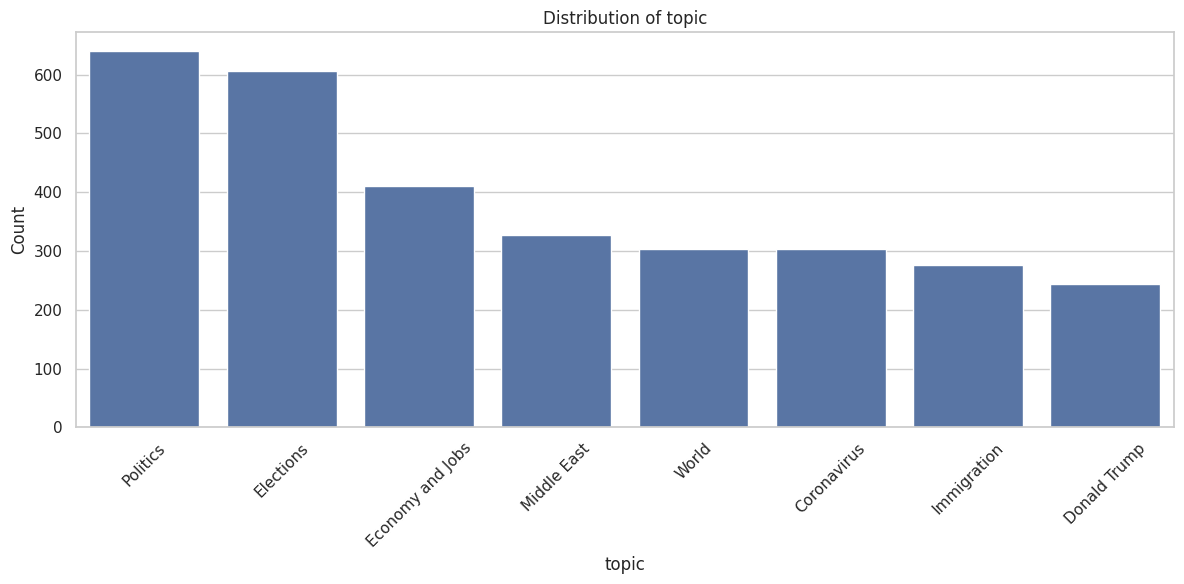

In [13]:
plot_column_distribution(train_df, "topic")

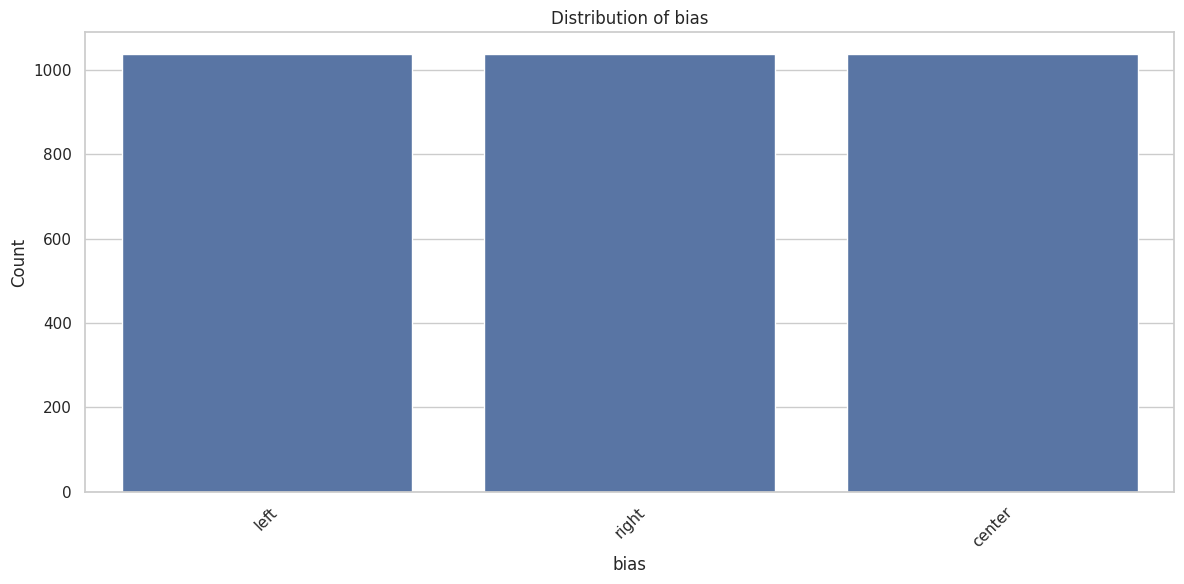

In [14]:
plot_column_distribution(train_df, "bias")

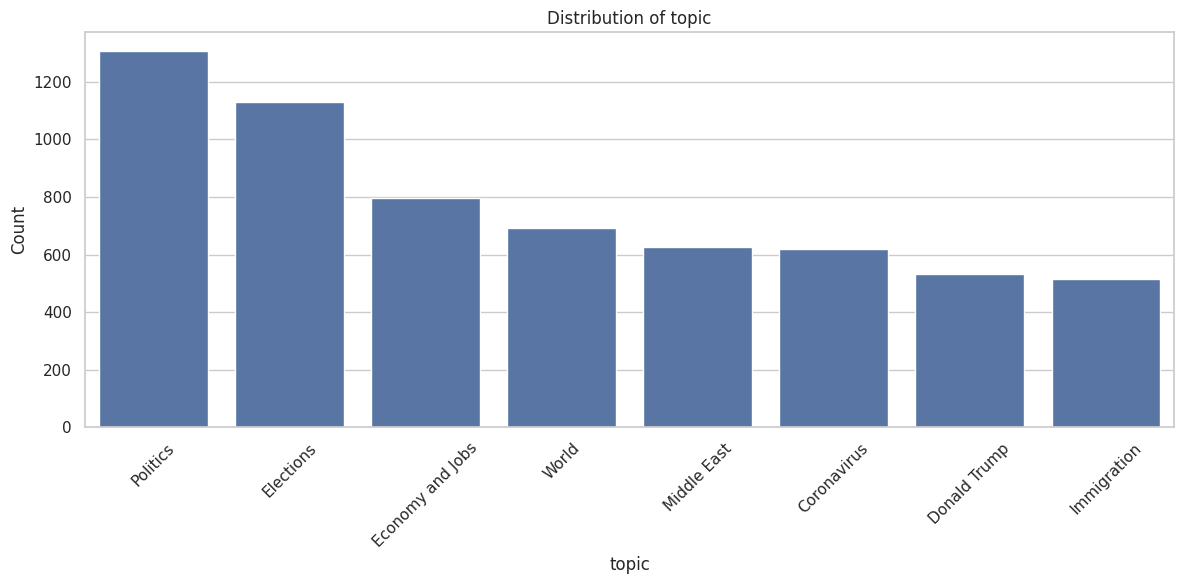

In [15]:
plot_column_distribution(test_df, "topic")

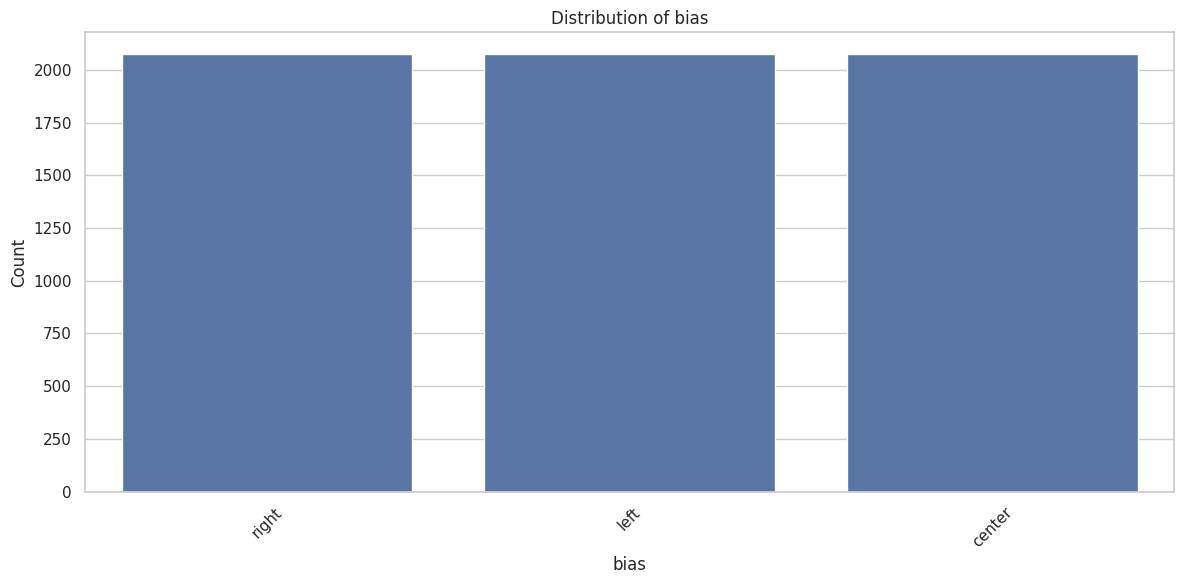

In [16]:
plot_column_distribution(test_df, "bias")

In [17]:
# save the dataframes to parquet
parquet_output_path = Path("data/newsbias2_train.parquet")
train_df.to_parquet(parquet_output_path, index=False)
parquet_output_path = Path("data/newsbias2_test.parquet")
test_df.to_parquet(parquet_output_path, index=False)